In [3]:
pip install rupture

     -------------------------------------- 474.1/474.1 kB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# import our custom classes 
from data import GestureRecognitionDataset
from model import Signal, GestureRecognitionModel

# import general classes for data processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Signal class
This is the workhorse of all the signal processing we do for this project. 
It also lets you visualize some aspects of the signal. 
For example, let's visualise the energy for one of the gestures. 

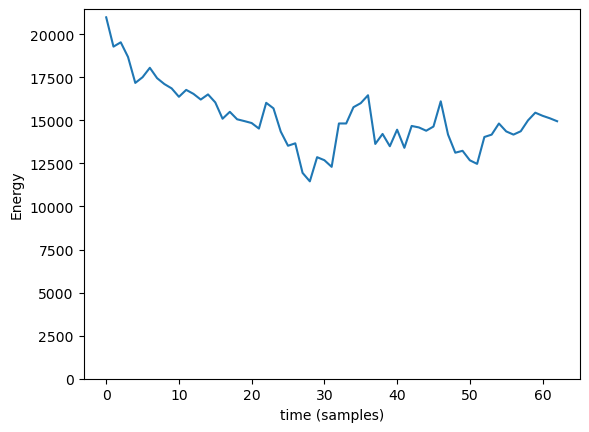

In [2]:
path_to_file = "data/dataset/Flex1/hand_close_2023-11-09T18-04-56.npy"
signal = Signal(path_to_file=path_to_file)
signal.display(attr="energy", w=5)

Right now the display module is very limited but you can implement your own plots if you'd like to look at specific aspects of the signal. 
Another thing you can look at is the average slope of energy (derivative wrt time). 

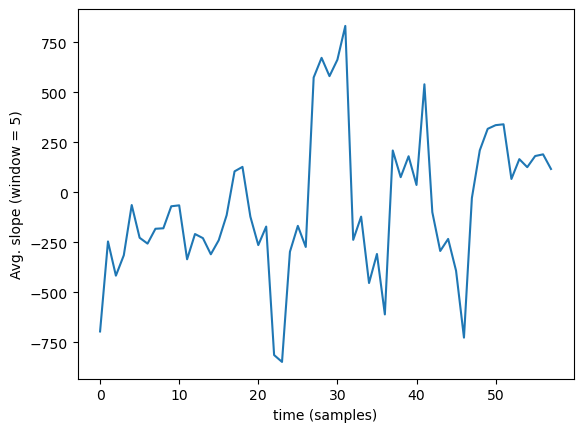

In [46]:
signal.display(attr="avg_slope_energy")

And you can change the window size to make the plots more or less granular. 

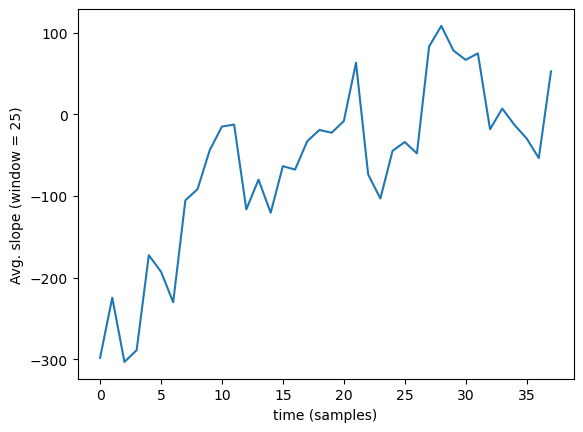

In [47]:
signal.display(attr="avg_slope_energy", w = 25)   # default is 5. you can see how increasing it smooths out the plot. 

<Figure size 640x480 with 0 Axes>

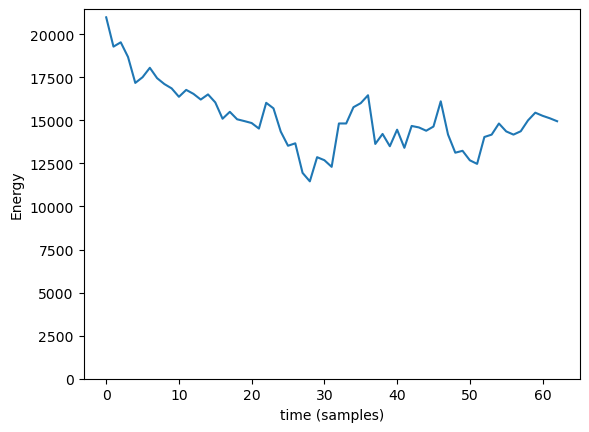

<Figure size 640x480 with 0 Axes>

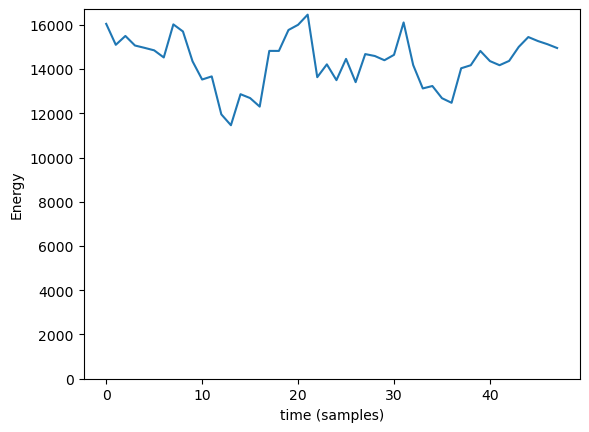

In [3]:
# Display the original signal
plt.figure()
signal.display(attr="energy", w=5)
plt.show()
# Remove transitions

signal.remove_transition()

# Display the signal after transition removal
plt.figure()
signal.display(attr="energy", w=5)
plt.show()

## The dataset class
This class takes in the raw data and processes it to create a csv file with the features. It's a standard classification type csv files with features and the ground truth label. 

It uses the Signal class 

In [4]:
# initialize dataset 
path_to_dataset = "data\dataset"          

gr = GestureRecognitionDataset(path_to_dataset=path_to_dataset,
                                    version="v2", save_df=False, 
                                    remove_transition=False)


In [5]:
# Not that you have a dataset object, we can call get features function on it which would return a pandas df
df = gr.get_features()

  0%|          | 0/829 [00:00<?, ?it/s]

100%|██████████| 829/829 [00:40<00:00, 20.65it/s]


### Task 1 - EDA
Get familiar with this dataframe. 
Look at what columns it has, which ones are features, which ones are metadata, which ones are labels etc. 
Maybe plot some things to get a sense of the distributions. Get comfy with things!

In [6]:
#df.head()
#df.shape
#subdata = df[["mav_1","gesture"]]
#subdata.head()
subset = df[["subject","take","gesture","timestamp"]]
#personas.head(400)
#timestamp = df[["timestamp"]]
#timestamp
subset.shape

(51027, 4)

In [7]:
subject = 'Flex'

df = df[(df['subject'] == subject)]

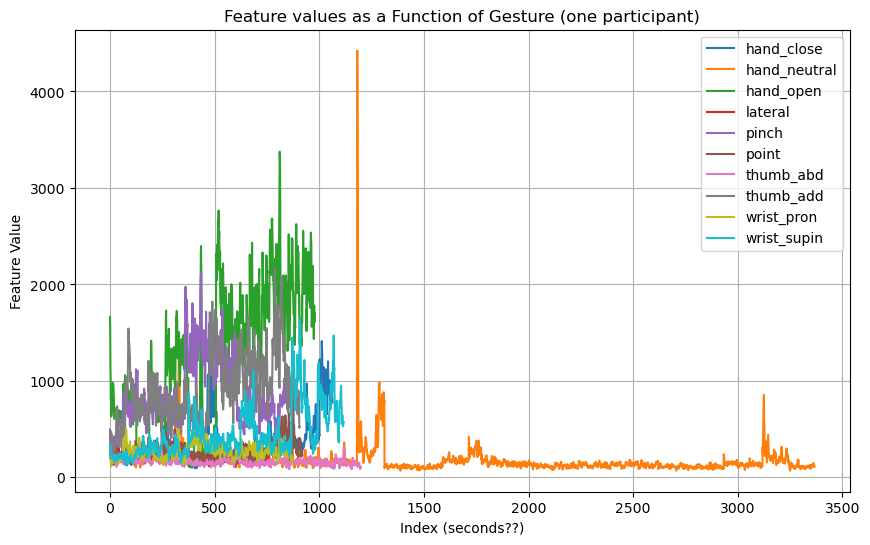

In [8]:
import matplotlib.pyplot as plt

# Extract the columns
feature = df['iasd_7']
gesture = df['gesture']

# Create a dictionary to store values for each category
categories = {}
for category, value in zip(gesture, feature):
    if category not in categories:
        categories[category] = []
    categories[category].append(value)

# Plotting
plt.figure(figsize=(10, 6))
for category, values in categories.items():
    plt.plot(values, label=category)

plt.xlabel('Index (seconds??)')
plt.ylabel('Feature Value')
plt.title('Feature values as a Function of Gesture (one participant)')
plt.legend()
plt.grid(True)
plt.show()

## Task 2 - Train a model with our model class

The model class is extremely simple at the moment. Which makes it a good use case to dive into our code and learn about object oriented programming. I would recommend reading a bit about classes in python. Ask questions if things don't make sense. 


In [9]:
# instantiate the model 
model = GestureRecognitionModel(model_name="xgboost")

In [10]:
df_train = df[(df['take'] == '1') | (df['take'] == '2')]
df_test = df[(df['take'] =='3' )]

## Exercise 
Read through the GestureRecognitionModel.py file in the model folder and figure out how you would train a model using it. 

We are using the python xgboost classifier learn as our backend. So looking through some guides on xgboost should give a good starting point. Something like this - https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/. 

Again ask questions if you're stuck somewhere! 

Expected outcome - a trained model and report accuracy. Doesn't have to be the most accurate model in the world!  

In [12]:
#selecting X (features) and Y (gestures) 
selected_columns = [ 'rms_0', 'rms_1', 'rms_2', 'rms_3', 'rms_4', 'rms_5', 'rms_6', 'rms_7',
           'wl_0', 'wl_1', 'wl_2', 'wl_3', 'wl_4', 'wl_5', 'wl_6', 'wl_7', 'var_0',
           'iasd_0','iasd_1', 'iasd_2', 'iasd_3', 'iasd_4', 'iasd_5', 'iasd_6', 'iasd_7',
           'iatd_0', 'iatd_1', 'iatd_2', 'iatd_3', 'iatd_4', 'iatd_5', 'iatd_6',
           'iatd_7']


# gebruiken: RMS, wl, iatd en iasd

# here I tested if the length of the features had any influence on the accuracy, this was not the case, so this can be skipped. 
# Find the length of the shortest column
#min_length = min(len(df[column]) for column in columns_x)

# Truncate each column to the length of the shortest column
#columns_x = [column[:min_length] for column in columns_x]

X_train = df_train[selected_columns]
y_train = df_train['gesture']
X_test = df_test[selected_columns]
y_test = df_test['gesture']

# encoding y to specify classes as numbers
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(y_train)
y_train = Y_encoded 

Y_encoded2 = label_encoder.fit_transform(y_test)
y_test = Y_encoded2 

# training model
model.train(X_train, y_train)

# making predictions with the testing subset
y_pred = model.predict(X_test)

# decoding y 
predictions = [round(value) for value in y_pred]
predicted_labels_decoded = label_encoder.inverse_transform(predictions)

# calculate and print accuracy
accuracy = accuracy_score(y_test, predictions)*100

print("The accuracy of the model is %.2f%%" % ( accuracy))

The accuracy of the model is 71.90%


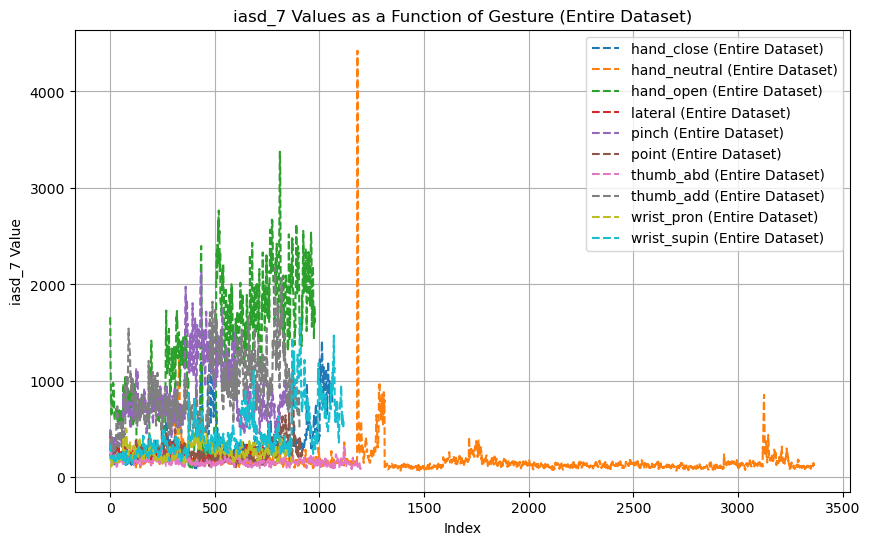

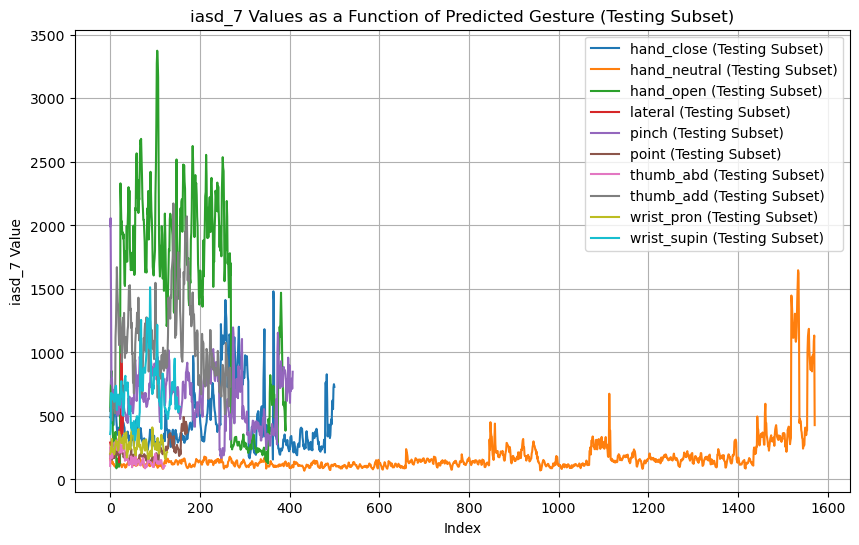

In [103]:
# here, I wanted to plot the initial values of the predicted classes of the testing setof an individual feature to compare it with the plot above

# select feature of interest
feature = 'iasd_7'

entire = df[feature]

# store values of each category
categories_entire = {}
for category, value in zip(df['gesture'], entire):
    if category not in categories_entire:
        categories_entire[category] = []
    categories_entire[category].append(value)

# plotting entire dataset as in figure above
plt.figure(figsize=(10, 6))
for category, values in categories_entire.items():
    plt.plot(values, label=f'{category} (Entire Dataset)', linestyle='--')

plt.xlabel('Index')
plt.ylabel(f'{feature} Value')  
plt.title(f'{feature} Values as a Function of Gesture (Entire Dataset)')
plt.legend()
plt.grid(True)
plt.show()

# select feature of interest in testing set
testing = X_test[feature]

# store values of each category
categories_testing = {}
for category, value in zip(predicted_labels_decoded, testing):
    if category not in categories_testing:
        categories_testing[category] = []
    categories_testing[category].append(value)

# store unique predicted classes
unique_predicted_classes = np.unique(predicted_labels_decoded)

# give it the same color to make comparison easier
color_map = plt.cm.get_cmap('tab10', len(unique_predicted_classes))

# plotting the feature of the predicted classes
plt.figure(figsize=(10, 6))
for i, category in enumerate(unique_predicted_classes):
    color = color_map(i)  # get color from color map
    if category in categories_testing:
        values = categories_testing[category]
        plt.plot(values, label=f'{category} (Testing Subset)', color=color)

plt.xlabel('Index')
plt.ylabel(f'{feature} Value')  
plt.title(f'{feature} Values as a Function of Predicted Gesture (Testing Subset)')
plt.legend()
plt.grid(True)
plt.show()

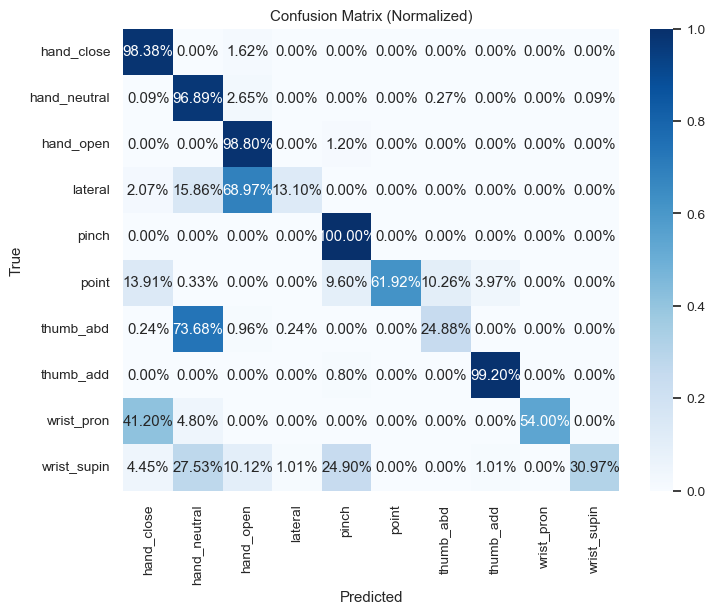

In [16]:
# plotting confusion matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Normalize confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get class labels
class_labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.9)  # Adjust to fit labels
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2%', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [19]:
# Determine F1 score per class

from sklearn.metrics import f1_score

# Calculate F1 score per class
f1_per_class = f1_score(y_test, predictions, average=None)

# Get class labels
class_labels = label_encoder.classes_

# Print F1 score per class
for label, f1 in zip(class_labels, f1_per_class):
    print(f"F1 score for class {label}: {f1:.2f}")

F1 score for class hand_close: 0.77
F1 score for class hand_neutral: 0.81
F1 score for class hand_open: 0.72
F1 score for class lateral: 0.22
F1 score for class pinch: 0.76
F1 score for class point: 0.76
F1 score for class thumb_abd: 0.37
F1 score for class thumb_add: 0.96
F1 score for class wrist_pron: 0.70
F1 score for class wrist_supin: 0.47


In [ ]:
# Here, 